In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV
import xgboost
%matplotlib inline
sns.set(style="white")

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [62]:
df = pd.read_csv(r"C:\Users\hp\Desktop\disha\nyc taxi\train.csv")
weather = pd.read_csv(r"C:\Users\hp\Desktop\disha\nyc taxi\weather-data-in-new-york-city-2016\wd.csv")
fastest1 = pd.read_csv(r"C:\Users\hp\Desktop\disha\nyc taxi\froute.csv")
fastest2 = pd.read_csv(r"C:\Users\hp\Desktop\disha\nyc taxi\route2.csv")
test = pd.read_csv(r"C:\Users\hp\Desktop\disha\nyc taxi\test.csv")
fastesttest = pd.read_csv(r"C:\Users\hp\Desktop\disha\nyc taxi\route1.csv")

In [63]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [64]:
df["passenger_count"].unique()

array([1, 6, 4, 2, 3, 5, 0, 7, 9, 8], dtype=int64)

In [65]:
df = df[df["passenger_count"]>0]

In [66]:
df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [67]:
df["pickup_datetime"] =pd.to_datetime(df["pickup_datetime"]) 

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x0000018C1F4E4080>>
Traceback (most recent call last):
  File "C:\Users\hp\Anaconda3\lib\site-packages\xgboost\core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


In [68]:
df["dropoff_datetime"] =pd.to_datetime(df["dropoff_datetime"]) 

In [69]:
df['pu_hour'] = df.pickup_datetime.dt.hour
df['yday'] = df.pickup_datetime.dt.dayofyear
df['wday'] = df.pickup_datetime.dt.dayofweek
df['month'] = df.pickup_datetime.dt.month

In [70]:
def dist(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    miles = km *  0.621371
    return miles

In [71]:
df["distance"] = dist(df.pickup_longitude,df.pickup_latitude,df.dropoff_longitude,df.dropoff_latitude)

In [72]:
weather["date"] = pd.to_datetime(weather["date"])

In [73]:
weather.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,2016-01-01,42,34,38.0,0.00,0.0,0
1,2016-02-01,40,32,36.0,0.00,0.0,0
2,2016-03-01,45,35,40.0,0.00,0.0,0
3,2016-04-01,36,14,25.0,0.00,0.0,0
4,2016-05-01,29,11,20.0,0.00,0.0,0


In [74]:
weather.dtypes

date                   datetime64[ns]
maximum temperature             int64
minimum temperature             int64
average temperature           float64
precipitation                  object
snow fall                      object
snow depth                     object
dtype: object

In [75]:
weather['yday'] = weather.date.dt.dayofyear

In [76]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pu_hour,yday,wday,month,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,74,0,3,0.930553
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,164,6,6,1.121185
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,19,1,1,3.965024
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,97,2,4,0.922466
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,86,5,3,0.738091


In [77]:
nyc = pd.merge(df,weather, on= "yday")

In [78]:
nyc = nyc.drop("date",axis=1)

In [79]:
nyc = nyc.drop(["maximum temperature","minimum temperature"],axis=1)

In [80]:
nyc.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pu_hour,yday,wday,month,distance,average temperature,precipitation,snow fall,snow depth
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,74,0,3,0.930553,45.5,0.29,0.0,0
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,N,1346,14,74,0,3,1.224702,45.5,0.29,0.0,0
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,N,695,15,74,0,3,1.563038,45.5,0.29,0.0,0
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944359,40.714489,-73.910530,40.709492,N,755,4,74,0,3,1.803896,45.5,0.29,0.0,0
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952881,40.766468,-73.978630,40.761921,N,1050,14,74,0,3,1.382767,45.5,0.29,0.0,0


In [81]:
corr = df.corr()
corr

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pu_hour,yday,wday,month,distance
vendor_id,1.000000,0.287425,0.007823,0.001732,0.001526,0.004484,0.020296,0.009305,-0.006025,0.001311,-0.006219,0.008114
passenger_count,0.287425,1.000000,0.002181,-0.005148,-0.000336,-0.002786,0.008480,0.009085,-0.001801,0.025206,-0.002157,0.010280
pickup_longitude,0.007823,0.002181,1.000000,0.022592,0.783580,0.100213,0.026515,0.010151,0.004259,-0.016357,0.004471,0.259792
pickup_latitude,0.001732,-0.005148,0.022592,1.000000,0.114913,0.493994,-0.029175,0.010598,-0.002526,-0.028973,-0.001446,-0.210381
dropoff_longitude,0.001526,-0.000336,0.783580,0.114913,1.000000,0.124895,0.014650,-0.022459,0.004606,-0.001133,0.004751,0.134052
dropoff_latitude,0.004484,-0.002786,0.100213,0.493994,0.124895,1.000000,-0.020649,0.013605,-0.001561,-0.021754,-0.000610,-0.142144
trip_duration,0.020296,0.008480,0.026515,-0.029175,0.014650,-0.020649,1.000000,0.003684,0.006611,-0.000687,0.006591,0.094790
pu_hour,0.009305,0.009085,0.010151,0.010598,-0.022459,0.013605,0.003684,1.000000,-0.003342,-0.084247,-0.003440,-0.015821
yday,-0.006025,-0.001801,0.004259,-0.002526,0.004606,-0.001561,0.006611,-0.003342,1.000000,-0.013612,0.985657,0.016443
wday,0.001311,0.025206,-0.016357,-0.028973,-0.001133,-0.021754,-0.000687,-0.084247,-0.013612,1.000000,-0.014541,0.007609


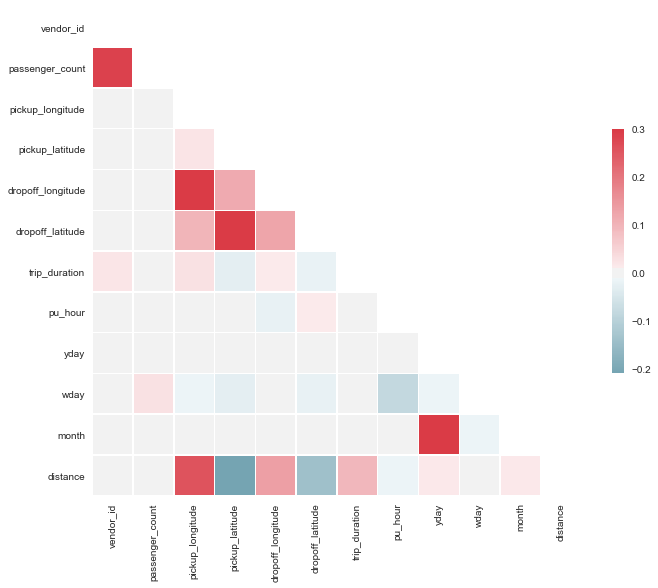

In [82]:
#make the correlation plot 
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

C:\Users\hp\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


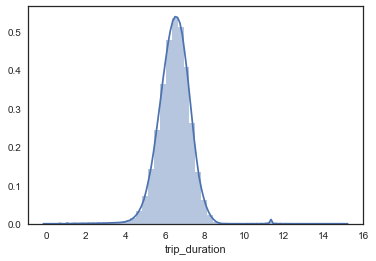

In [83]:
sns.distplot(np.log(df["trip_duration"]))

the above plot shows that, trip-durations are like Gaussian and few trips have very large duration

In [84]:
df["trip_duration"].max()

3526282

this is in sec, which is almost equivalent to 100hrs

In [85]:
df["distance"].max()

770.580556284328

C:\Users\hp\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\hp\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\hp\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\hp\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


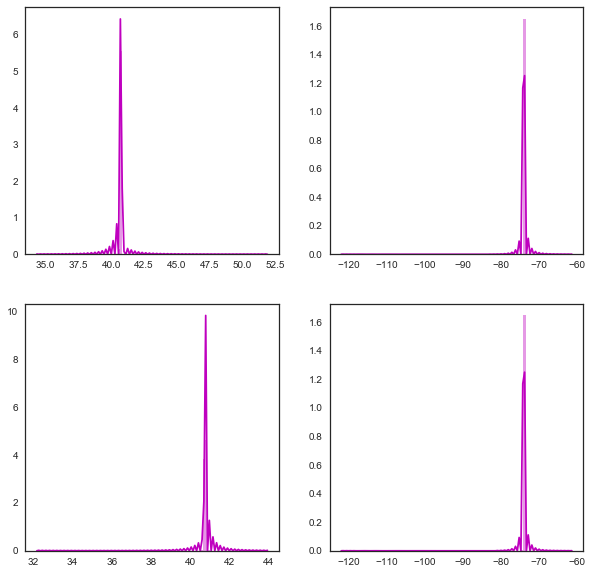

In [86]:
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)

sns.distplot(df['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(df['pickup_longitude'].values, label = 'pickup_longitude',color="m",bins =100, ax=axes[0,1])
sns.distplot(df['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(df['dropoff_longitude'].values, label = 'dropoff_longitude',color="m",bins =100, ax=axes[1, 1])


From the plot above it is clear that pick and drop latitude are centered around 40 to 41, and longitude are situated around -74 to -73. 

In [87]:
mask = ((nyc.trip_duration > 60) & (nyc.distance < 0.05))
nyc = nyc[~mask]
mask = (nyc.trip_duration < 60) 
nyc = nyc[~mask]
mask =  nyc.trip_duration > 79200
nyc = nyc[~mask]
mask = nyc.distance/(nyc.trip_duration/3600) > 60
nyc = nyc[~mask]


In [113]:
fastest = pd.concat([fastest1,fastest2],ignore_index = True)

In [114]:
fastest = fastest.drop(['step_location_list','step_direction','step_maneuvers','travel_time_per_step','distance_per_step','street_for_each_step','number_of_steps','starting_street','end_street'],axis=1)

In [115]:
fastest.head()

,id,total_distance,total_travel_time
0,id2875421,2009.1,164.9
1,id2377394,2513.2,332.0
2,id3504673,1779.4,235.8
3,id2181028,1614.9,140.1
4,id0801584,1393.5,189.4


In [116]:
nyc = pd.merge(nyc,fastest,on='id',how='outer')

In [117]:
nyc.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,snow fall,snow depth,total_distance_x,total_travel_time_x,snowfall,snowdepth,total_distance_y,total_travel_time_y,total_distance,total_travel_time
0,id2875421,2.0,2016-03-14 17:24:55,2016-03-14 17:32:30,1.0,-73.982155,40.767937,-73.964630,40.765602,N,...,0.0,0,2009.1,164.9,0.0,0.0,2009.1,164.9,2009.1,164.9
1,id2129090,1.0,2016-03-14 14:05:39,2016-03-14 14:28:05,1.0,-73.975090,40.758766,-73.953201,40.765068,N,...,0.0,0,2782.9,244.6,0.0,0.0,2782.9,244.6,2782.9,244.6
2,id0256505,1.0,2016-03-14 15:04:38,2016-03-14 15:16:13,1.0,-73.994484,40.745087,-73.998993,40.722710,N,...,0.0,0,3124.4,419.9,0.0,0.0,3124.4,419.9,3124.4,419.9
3,id3863815,2.0,2016-03-14 04:24:36,2016-03-14 04:37:11,3.0,-73.944359,40.714489,-73.910530,40.709492,N,...,0.0,0,3327.8,280.8,0.0,0.0,3327.8,280.8,3327.8,280.8
4,id3817493,2.0,2016-03-14 14:57:56,2016-03-14 15:15:26,1.0,-73.952881,40.766468,-73.978630,40.761921,N,...,0.0,0,3354.8,270.3,0.0,0.0,3354.8,270.3,3354.8,270.3


In [99]:
nyc["vendor_id"].unique()

array([ 2.,  1., nan])

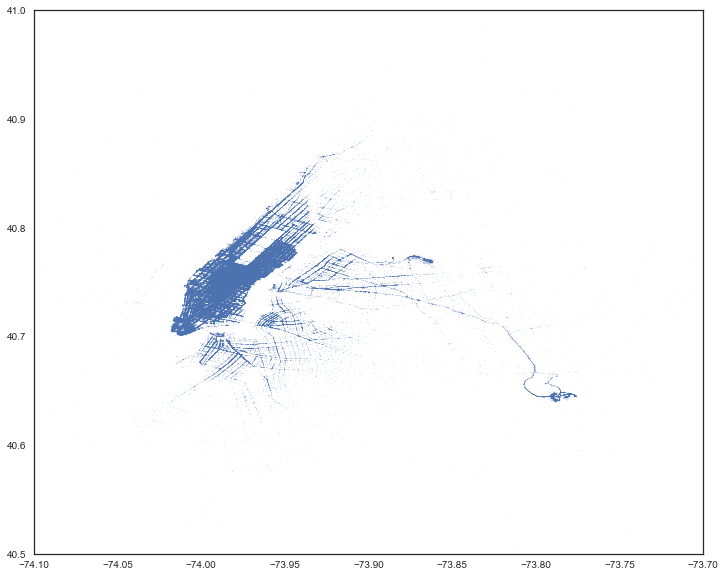

In [100]:
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
plt.ylim(40.5, 41)
plt.xlim(-74.1,-73.7)

ax.scatter(nyc['pickup_longitude'],nyc['pickup_latitude'], s=0.01, alpha=1)

In [101]:
nyc['snowfall'] = nyc['snow fall'].replace(['T'],0.05).astype("float64")
nyc['precipitation'] = nyc['precipitation'].replace(['T'],0.05).astype("float64")
nyc['snowdepth'] = nyc['snow depth'].replace(['T'],0.05).astype("float64")

In [102]:
### working with test data

In [135]:
test =  pd.read_csv(r"C:\Users\hp\Desktop\disha\nyc taxi\test.csv")

In [136]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [137]:
test["pickup_datetime"] = pd.to_datetime(test["pickup_datetime"])

In [138]:
test["pu_hour"] = test["pickup_datetime"].dt.hour
test["yday"] = test["pickup_datetime"].dt.dayofyear
test["wday"] = test["pickup_datetime"].dt.dayofweek
test["month"] = test["pickup_datetime"].dt.month

In [139]:
test = pd.merge(test,fastesttest,on="id",how="outer")

In [140]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pu_hour,...,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,23,...,8th Avenue,3795.9,424.6,4,3rd Avenue|East 37th Street|8th Avenue|8th Avenue,1983.3|1482.8|329.7|0,270.9|116.9|36.8|0,depart|turn|turn|arrive,none|left|right|arrive,"-73.988109,40.732021|-73.976697,40.747615|-73...."
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,23,...,Flatbush Avenue,2904.5,200.0,4,Washington Avenue|Empire Boulevard|Flatbush Av...,1878.5|125.2|900.8|0,135.9|14.4|49.7|0,depart|turn|turn|arrive,none|right|left|arrive,"-73.96419,40.679994|-73.960956,40.663285|-73.9..."
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,23,...,East 10th Street,1499.5,193.2,4,West 14th Street|Broadway|East 10th Street|Eas...,641.9|346.9|510.7|0,80.5|49.6|63.1|0,depart|turn|turn|arrive,none|right|left|arrive,"-73.997421,40.737604|-73.990752,40.734816|-73...."
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,23,...,East 11th Street,7023.9,494.8,11,2nd Avenue|East 76th Street|1st Avenue|East 79...,65.5|228.2|247.6|559.3|123.1|4132|49.2|494.1|1...,10.9|40.3|21.7|40.7|9.8|157.9|5.5|64.7|142.4|0...,depart|turn|turn|turn|on ramp|merge|off ramp|t...,none|left|left|right|straight|slight left|slig...,"-73.956096,40.771911|-73.956473,40.771396|-73...."
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,23,...,East 55th Street,1108.2,103.2,4,East 57th Street|Sutton Place South|East 55th ...,925|165.8|17.4|0,67.4|33.3|2.5|0,depart|turn|turn|arrive,left|right|left|arrive,"-73.970262,40.761412|-73.960671,40.757364|-73...."


In [141]:
test = pd.merge(test,weather,on="yday")

In [142]:
test = test.drop(["date","maximum temperature", "minimum temperature"],axis=1)

In [143]:
test['snowfall'] = test['snow fall'].replace(['T'],0.05).astype("float64")
test['precipitation'] = test['precipitation'].replace(['T'],0.05).astype("float64")
test['snowdepth'] = test['snow depth'].replace(['T'],0.05).astype("float64")

In [144]:
test = test.drop(["snow fall","snow depth"],axis=1)

In [145]:
X = nyc[['vendor_id','passenger_count','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','pu_hour','wday','month','precipitation','snowfall','snowdepth','total_distance','total_travel_time']]
y = nyc['trip_duration']

In [146]:
test_f = test[['vendor_id','passenger_count','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','pu_hour','wday','month','precipitation','snowfall','snowdepth','total_distance','total_travel_time']]

In [147]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.01, gamma=0, subsample=0.75,colsample_bytree=1, max_depth=7)
xgb.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [148]:
predictions = xgb.predict(test_f)

In [150]:
predictions[predictions<0]=0
test['trip_duration']=predictions.astype(int)
output = test[['id','trip_duration']]
output['trip_duration'].isnull().values.any()


C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


False

In [153]:
# GridSearchCV